In [1]:
import joblib
import pandas as pd

In [3]:
data = joblib.load("../data/tickerdata/T.bin")
data.shape

(57, 9)

In [4]:
data

,title,date,query,url,ticker,content,ps_content,ps_content_filter,sim
126510,BRIEF-AT&T Inc Says To Close Additional AT&T S...,2020-03-21,AT%26T+Inc.,https://www.reuters.com/article/idUSFWN2BE05R,T,March 21 (Reuters) - AT&T Inc: * AT&T INC SAYS...,,empty content,1.0
126512,BRIEF-T. Rowe Price Associates Inc Reports 15....,2020-03-19,AT%26T+Inc.,https://www.reuters.com/article/idUSFWN2BB1DZ,T,March 18 (Reuters) - T. ROWE PRICE ASSOCIATES:...,,empty content,1.0
126513,BRIEF-T. Rowe Price Group Inc Says CEO William...,2020-03-25,AT%26T+Inc.,https://www.reuters.com/article/idUSFWN2BI1AY,T,March 25 (Reuters) - T. Rowe Price Group Inc: ...,,empty content,1.0
126514,T-Mobile completes merger with Sprint,2020-04-01,AT%26T+Inc.,https://www.reuters.com/article/idUSL4N2BP3NA,T,April 1 (Reuters) - T-Mobile US Inc said on We...,April 1 (Reuters) - T-Mobile US Inc said on We...,April 1 (Reuters) - T-Mobile US Inc said on We...,1.0
126515,T-Mobile CEO takes the stand in T-Mobile/Sprin...,2019-12-13,AT%26T+Inc.,https://www.reuters.com/article/idUSKBN1YH2CU,T,(Reuters) - T-Mobile US Inc Chief Executive Jo...,The states have argued that Dish has a history...,The states have argued that Dish has a history...,1.0
126516,RPT-BRIEF-T-Mobile Completes Merger With Sprin...,2020-04-01,AT%26T+Inc.,https://www.reuters.com/article/idUSL4N2BP3LW,T,(Repeats with no changes to text) April 1 (Reu...,,empty content,1.0
126517,UPDATE 2-T-Mobile completes merger with Sprint,2020-04-01,AT%26T+Inc.,https://www.reuters.com/article/idUSL4N2BP3O2,T,(Reuters) - T-Mobile US Inc said on Wednesday ...,(Reuters) - T-Mobile US Inc said on Wednesday ...,(Reuters) - T-Mobile US Inc said on Wednesday ...,1.0
126518,"AT&T plans to cut over 3,000 jobs: Union",2020-06-16,AT%26T+Inc.,https://www.reuters.com/article/idUSL4N2DT40G,T,June 16 (Reuters) - AT&T Inc has informed Comm...,(Reporting by Akanksha Rana in Bengaluru; Edit...,(Reporting by Akanksha Rana in Bengaluru; Edit...,1.0
126519,AT&T names Jason Kilar as CEO of WarnerMedia,2020-04-01,AT%26T+Inc.,https://www.reuters.com/article/idUSL4N2BP3YG,T,April 1 (Reuters) - AT&T Inc on Wednesday name...,(Reporting by Ayanti Bera in Bengaluru; Editin...,(Reporting by Ayanti Bera in Bengaluru; Editin...,1.0
126520,T-Mobile tops fourth-quarter revenue estimates,2020-02-06,AT%26T+Inc.,https://www.reuters.com/article/idUSL4N2A64NB,T,Feb 6 (Reuters) - T-Mobile US Inc beat Wall St...,The company added 1 million net new monthly pa...,The company added 1 million net new monthly pa...,1.0


In [5]:
for content in data.content:
    print(content)
    print("="*50)

March 21 (Reuters) - AT&T Inc: * AT&T INC SAYS TO CLOSE ADDITIONAL AT&T STORES ACROSS U.S., SIGNIFICANTLY REDUCING RETAIL FOOTPRINT TO A MINIMUM NUMBER OF LOCATIONS Further company coverage:
March 18 (Reuters) - T. ROWE PRICE ASSOCIATES: * T. ROWE PRICE ASSOCIATES INC REPORTS 15.7% STAKE IN RANGER ENERGY SERVICES INC AS OF MARCH 12, 2020 - SEC FILING Source text: (‍here ​) Further company coverage:
March 25 (Reuters) - T. Rowe Price Group Inc: * T. ROWE PRICE GROUP INC SAYS CEO WILLIAM STROMBERG’S FY 2019 TOTAL COMPENSATION WAS $14.6 MILLION VERSUS $13.1 MILLION IN FY 2018 - SEC FILING * T. ROWE PRICE GROUP INC SAYS CHIEF INVESTMENT OFFICER, ROBERT SHARPS’S FY 2019 TOTAL COMPENSATION WAS $14.1 MILLION VERSUS $12.6 MILLION IN FY 2018 * T. ROWE PRICE GROUP SAYS CFO CÉLINE DUFÉTEL’S FY 2019 TOTAL COMPENSATION WAS $6.1 MILLION VERSUS $3.8 MILLION IN FY 2018 * T. ROWE PRICE GROUP INC SAYS FOR 2019, CEO PAY RATIO WAS 133:1 Source text : (bit.ly/2Jfuzii) Further company coverage:
April 1 (Reu

In [6]:
data.shape[0] - data.drop_duplicates(subset="content").shape[0]

4

In [7]:
ids = data["content"]
data[ids.isin(ids[ids.duplicated()])]

,title,date,query,url,ticker,content,ps_content,ps_content_filter,sim
126521,AT&T says it will continue investing in Mexico...,2019-12-17,AT%26T+Inc.,https://www.reuters.com/article/idUSKBN1YL24T,T,MEXICO CITY (Reuters) - Mexican President Andr...,Reporting by Diego Ore; editing by Julia LoveA...,Reporting by Diego Ore; editing by Julia LoveA...,1.0
126523,AT&T says it will continue investing in Mexico...,2019-12-17,AT%26T+Inc.,https://www.reuters.com/article/idUSE1N28100P,T,MEXICO CITY (Reuters) - Mexican President Andr...,Reporting by Diego Ore; editing by Julia LoveA...,Reporting by Diego Ore; editing by Julia LoveA...,1.0
126551,AT&T denies investors a dial-in as annual mee...,2020-04-17,AT%26T+Inc.,https://www.reuters.com/article/idUSKBN21Z1KT,T,BOSTON (Reuters) - Activist investors say tele...,The meeting originally was to be held in Dalla...,The meeting originally was to be held in Dalla...,1.0
126561,UPDATE 1-AT&T denies investors a dial-in as a...,2020-04-17,AT%26T+Inc.,https://www.reuters.com/article/idUSL1N2C50OV,T,BOSTON (Reuters) - Activist investors say tele...,The meeting originally was to be held in Dalla...,The meeting originally was to be held in Dalla...,1.0
126562,UPDATE 2-T-Mobile shares priced at $103 each i...,2020-06-24,AT%26T+Inc.,https://www.reuters.com/article/idUSL1N2E107O,T,(Reuters) - U.S. wireless carrier T-Mobile US ...,(Reuters) - U.S. wireless carrier T-Mobile US ...,(Reuters) - U.S. wireless carrier T-Mobile US ...,1.0
126563,T-Mobile shares priced at $103 each in SoftBan...,2020-06-24,AT%26T+Inc.,https://www.reuters.com/article/idUSKBN23U3IA,T,(Reuters) - U.S. wireless carrier T-Mobile US ...,NaN,empty content,1.0
126564,'Terrible' WeWork bet caused us headaches -T. ...,2020-02-14,AT%26T+Inc.,https://www.reuters.com/article/idUSL4N2AE1XG,T,(Reuters) - Asset management firm T. Rowe Pric...,In a rare public comment on its experience wit...,In a rare public comment on its experience wit...,1.0
126565,'Terrible' WeWork bet caused us headaches: T. ...,2020-02-14,AT%26T+Inc.,https://www.reuters.com/article/idUSKBN2081DF,T,(Reuters) - Asset management firm T. Rowe Pric...,NaN,empty content,1.0


In [2]:
df = joblib.load("../data/sp500_top100_v4.bin")
df.head()

,title,date,query,url,ticker,content,ps_content,ps_content_filter,sim
0,BRIEF-Apple Inc Says Not Allowing Entertainmen...,2020-03-15,Apple Inc.,https://www.reuters.com/article/idUSFWN2B61K2,AAPL,March 14 (Reuters) - Apple Inc: * APPLE INC SA...,,empty content,1.0
1,Apple signs multi-year deals with major music ...,2020-03-12,Apple Inc.,https://www.reuters.com/article/idUSKBN20Z33J,AAPL,(Reuters) - Apple Inc has sealed multi-year li...,(Reuters) - Apple Inc has sealed multi-year li...,(Reuters) - Apple Inc has sealed multi-year li...,1.0
2,Apple signs multi-year deals with major music ...,2020-03-12,Apple Inc.,https://www.reuters.com/article/idUSL4N2B54T2,AAPL,(Reuters) - Apple Inc has sealed multi-year li...,NaN,empty content,1.0
3,Chinese regulators remove 'Plague Inc' game fr...,2020-02-28,Apple Inc.,https://www.reuters.com/article/idUSKCN20M043,AAPL,BEIJING/SHANGHAI (Reuters) - The video game “P...,The regulator did not respond to Reuters phone...,The regulator did not respond to Reuters phone...,1.0
4,UPDATE 1-Chinese regulators remove 'Plague Inc...,2020-02-28,Apple Inc.,https://www.reuters.com/article/idUSL3N2AS0OO,AAPL,BEIJING/SHANGHAI (Reuters) - The video game “P...,NaN,empty content,1.0


In [2]:
from cool import transform

df = joblib.load("../data/tickerdata/ADBE.bin")
result_df = transform(df)
result_df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\YangWang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████████████████████████████████████████████████████████████████| 278/278 [03:02<00:00,  1.52it/s]


,ticker,date,Top 1 News,Top 2 News,Top 3 News,Top 4 News,Top 5 News,Top 6 News,Top 7 News,Top 8 News,...,Top 16 News,Top 17 News,Top 18 News,Top 19 News,Top 20 News,Top 21 News,Top 22 News,Top 23 News,Top 24 News,Top 25 News
0,ADBE,2013-05-10,The core problem: Spy tools and cyber-weapons ...,Yet neither of the two major U.S. initiatives ...,Swedish Defense Research Agency expert David L...,Computer researchers in the public and private...,When a U.S. agency knows about a vulnerability...,What’s certain is that criminal hackers copied...,Microsoft won’t say whether it has confronted ...,“My job was to have 25 zero-days on a USB stic...,...,A spokesman for the NSA agreed that the prolif...,"In their most common use, exploits are critica...",Defense contractors and agencies spend at leas...,“If the U.S. government knows of a vulnerabili...,Chinese officials deny the allegations and say...,"Those that do offer “bounties”, including Goog...","Moreover, when the U.S. launches a program con...",Experts say it was designed to steal industria...,The flaw became the second-most frequently tri...,"Eventually, the truth came out: The only place..."
1,ADBE,2012-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ADBE,2013-02-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ADBE,2012-10-18,The FTC is not likely to demand actions nearly...,Regulators are looking into whether Google is ...,"Most investors don’t fully understand that, pr...",The bar for antitrust enforcement remains high.,"Rather, it is likely to press the company to d...",The risk is that it could get ensnared in comp...,Google appeared to suffer a blip in the second...,"In the longer term, a rising wave of regulator...",...,Rising advertising rates for mobile searches a...,"To break through that level, investors and ana...",NEW YORK/SAN FRANCISCO (Reuters) - Google Inc’...,Google stock has hovered near an all-time high...,The most immediate concerns center on competit...,And the company has not yet articulated a cohe...,"To be sure, of 45 investment brokerages that c...","Among portfolio managers, at least one maintai...","“To date they’ve done well managing it,” Forre...",“But I think it’s their big risk.
4,ADBE,2014-10-02,Cutting obesity decreases risks of diabetes an...,Whether wellness programs can cut costs is an ...,"John Adams, the thirteenth employee at Twitter...",“We see a lot of experimenting going on.” Sili...,Google says it was among the first to first to...,Now 17 percent of surveyed high-tech companies...,"Last year, shortly after Yahoo CEO Marissa May...",The percent of companies offering rewards and ...,...,But about 50 percent of Intuit employees sport...,Intuit give employees cash for increasing thei...,Benefits managers say they only look at data i...,Silicon Valley is not alone in focusing on wel...,The researcher found that tech already is ahea...,"Moreover, only 23 percent of tech workers are ...","Google, for one, is using low tech to help avo...","Although it offers free food, it doesn’t want ...",The low-tech answer?,Sweets are put on a shelf that’s harder to see.


Sparsity Ratio: 0.2891020516919797


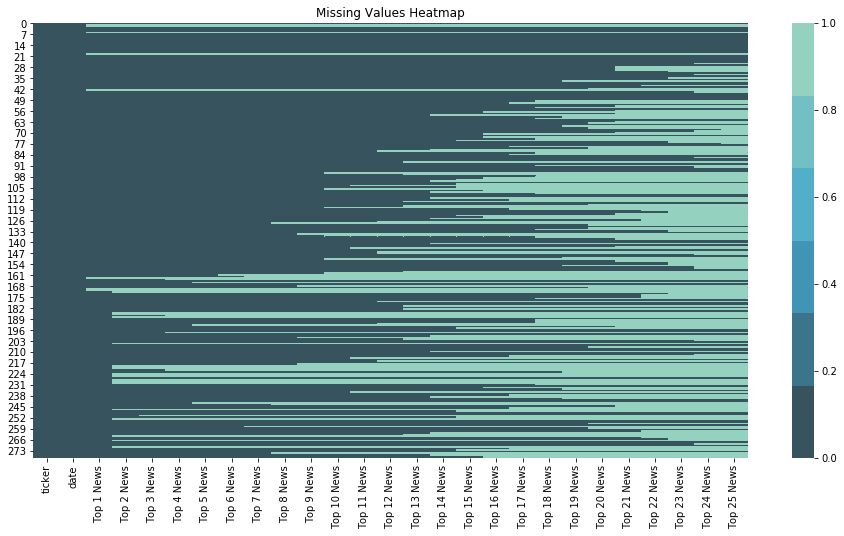

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def check_nan(df):
    sparse = df.isna().sum().sum()
    total = df.shape[0] * df.shape[1]
    ratio = sparse / total
    print("Sparsity Ratio: {}".format(ratio))
    plt.figure(figsize=(16, 8))
    sns.heatmap(df.isnull(), cbar=True, cmap=sns.color_palette("GnBu_d"))
    plt.title("Missing Values Heatmap")
    plt.show()
    
check_nan(result_df)